In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Model

In [2]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split, random_state=42)

### Enter your tag as unique id for saving

In [3]:
tag = str("autoencoder-18032023")

In [4]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()
encoding_dim = 3
inputLayer = Input(shape=(x_train.shape[1],))
encoded = Dense(encoding_dim, activation="relu")(inputLayer) # activity_regularizer=regularizers.l1(10e-5)
decoded = Dense(x_train.shape[1], activation="relu")(encoded)
autoencoder = Model(inputLayer, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 3)                 18        
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Encoder
encoder = Model(inputLayer, encoded)
# Decoder
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [6]:
#Training
def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.0001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

autoencoder.compile(optimizer = optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

autoencoder_history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

Epoch 1/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0570 - mean_absolute_error: 0.1669 - val_loss: 0.0584 - val_mean_absolute_error: 0.1715 - lr: 0.0500
Epoch 2/50
31/31 [==============================] - 0s 2ms/step - loss: 0.0319 - mean_absolute_error: 0.1225 - val_loss: 0.0156 - val_mean_absolute_error: 0.0742 - lr: 0.0500
Epoch 3/50
31/31 [==============================] - 0s 2ms/step - loss: 0.0190 - mean_absolute_error: 0.0932 - val_loss: 0.0213 - val_mean_absolute_error: 0.1015 - lr: 0.0500
Epoch 4/50
31/31 [==============================] - 0s 2ms/step - loss: 0.0181 - mean_absolute_error: 0.0921 - val_loss: 0.0308 - val_mean_absolute_error: 0.1152 - lr: 0.0500
Epoch 5/50
31/31 [==============================] - 0s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.0899 - val_loss: 0.0260 - val_mean_absolute_error: 0.1078 - lr: 0.0500
Epoch 6/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0193 - mean_absolute_error: 0.0909 - val_loss: 0.01

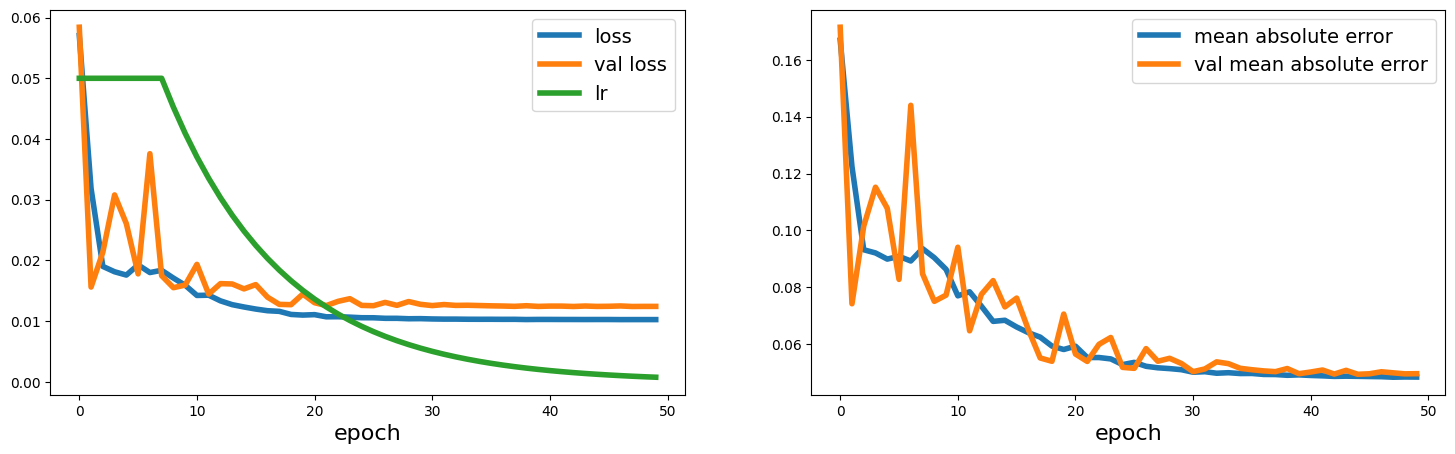

In [7]:
def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)

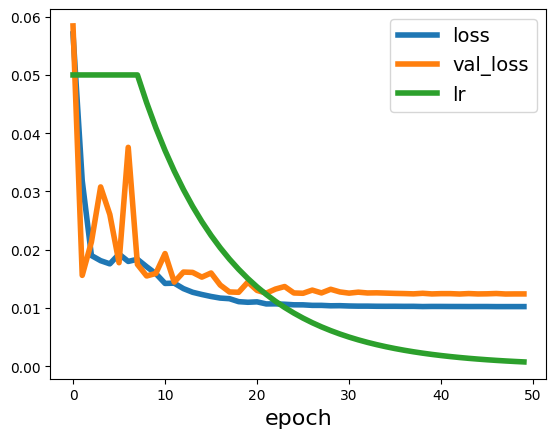

In [8]:
fig = plt.figure()
plt.plot(autoencoder_history.history['loss'], lw=4, label='loss')
plt.plot(autoencoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(autoencoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [9]:
encoded_train = encoder.predict(x_train)
np.save("data/ENCdata_"+tag+".npy", encoded_train)

32/32 [==============================] - 0s 544us/step


In [10]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')

16/16 [==============================] - 0s 601us/step
Data: [0.01010101 0.         1.         0.         0.05019733] to be: [0.         0.03924647 1.1942295 ] and rebuilded it to: [0.         0.00606247 1.0078614  0.         0.05240655]


In [11]:
encoder.save("archive/encoderModel-"+tag+".h5")
autoencoder.save("archive/completeModel-"+tag+".h5")
config = encoder.get_config()
np.save("archive/encoderConfig-"+tag+".npy", config)
config = autoencoder.get_config()
np.save("archive/completeConfig-"+tag+".npy", config)

In [12]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 3)                 18        
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________
